In [2]:
import os
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from uuid import uuid4
uuid = uuid4()
PICKLENAME = f"qm_calcs_{uuid}.pickle"


from pathlib import Path
import numpy as np
import ase
from ase.io import read
from ase.visualize import view

import itertools
import sys

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/tests/supermolecule")
from supermol import compute_interaction_energy

sys.path.append("/pchem-data/meuwly/boittier/home/pyscfgpu/helper_functions/")
from basis import *


import os
os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


sys.path.append("/pchem-data/meuwly/boittier/home/project-mmml/eric-copy/")


from pycharmmCommands import header, pbcs, nbonds, heat, equi, dyna, mini

from tqdm import tqdm



packmol_input = str(Path("packmol.inp").absolute())

import os
import shutil
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import numpy as np

import ase
from ase import Atoms, io
from ase.data import covalent_radii
from ase.io.pov import get_bondpairs, set_high_bondorder_pairs
from ase.visualize.plot import plot_atoms


from sklearn.decomposition import PCA

default_color_dict = {
    "Cl": [102, 227, 115],
    "C": [61, 61, 64],
    "O": [240, 10, 10],
    "N": [10, 10, 240],
    "F": [0, 232, 0],
    "H": [232, 206, 202],
    "K": [128, 50, 100],
    "X": [200, 200, 200],
}



def render_povray(
    atoms, pov_name, rotation="0x, 0y, 0z", radius_scale=0.25, color_dict=None,
    vectors = None, angles = None, planes = None,
):

    # align the molecule to the principal axes
    pca = PCA(n_components=3)
    pca.fit(atoms.get_positions())
    atoms.set_positions(pca.transform(atoms.get_positions()))

    if color_dict is None:
        color_dict = default_color_dict

    path = Path(pov_name)
    pov_name = path.name
    base = path.parent

    radius_list = []
    for atomic_number in atoms.get_atomic_numbers():
        radius_list.append(radius_scale * covalent_radii[atomic_number])

    colors = np.array([color_dict[atom.symbol] for atom in atoms]) / 255

    bondpairs = get_bondpairs(atoms, radius=0.9)
    good_bonds = []
    good_bond_keys = []
    for _ in bondpairs:
        #  remove the Cl-Cl bonds
        if not (atoms[_[0]].symbol == "Cl" and atoms[_[1]].symbol == "Cl"):
            good_bonds.append(_)
            good_bond_keys.append((_[0], _[1]))
            good_bond_keys.append((_[1], _[0]))

    # create hydrogen bonds
    _pos = atoms.get_positions()
    _z = atoms.get_atomic_numbers()
    idx_onh = (_z == 8) | (_z == 1) | (_z == 7)
    idxs = np.where(idx_onh)[0]

    # create a mapping between atom idxs in the first atoms object
    # and the idxs in the new atoms object
    map = {}
    for i, idx in enumerate(idxs):
        map[i] = idx
    # create a new atoms object with only N, O and H atoms
    atoms_onh = Atoms(_z[idxs], _pos[idxs])
    bondpairs_onh = get_bondpairs(atoms_onh, radius=1.5)
    for _ in bondpairs_onh:
        if (map[_[0]], map[_[1]]) not in good_bond_keys:
            distance = np.linalg.norm(_pos[_[0]] - _pos[_[1]])
            # check that atom1 is H or N/O and atom2 is N/O or H
            if (_z[_[0]] == 1 and (_z[_[1]] == 7 or _z[_[1]] == 8)) or (
                _z[_[1]] == 1 and (_z[_[0]] == 7 or _z[_[0]] == 8)
            ):
                if 1.0 < distance < 3.5:
                    print(f"Adding bond between", map[_[0]], map[_[1]])
                    good_bonds.append(_)

    good_bonds = set_high_bondorder_pairs(good_bonds)

    kwargs = {  # For povray files only
        "transparent": True,  # Transparent background
        "canvas_width": 1028*2,  # Width of canvas in pixels
        "canvas_height": None,  # None,  # Height of canvas in pixels
        "camera_dist": 10,  # Distance from camera to front atom,
        "camera_type": "orthographic angle 0",  # 'perspective angle 20'
        "depth_cueing": False,
        "colors": colors,
        "bondatoms": good_bonds,
        "textures": ["jmol"] * len(atoms),
        'image_plane'  : None,
    }

    generic_projection_settings = {
        "rotation": rotation,
        "radii": radius_list,
    }

    povobj = io.write(
        pov_name, atoms, **generic_projection_settings, povray_settings=kwargs
    )


    from ase.io.utils import PlottingVariables
    pvars = PlottingVariables(ase_atoms, scale=1,
                              **generic_projection_settings)
    R = pvars.positions
    w = pvars.w
    h = pvars.h
    z0 = R[:, 2].max()
    shift = (w /2 , h /2 , z0)
    
    R = pvars.positions[:len(atoms)] - shift
    

    
    def center_normal(plane):
        plane = np.array(plane)
        center = plane.T.mean(axis=1)
        return center, np.linalg.norm(plane.T, axis=1)


    with open("render_povray.pov") as f:
        lines = f.readlines()
        
    with open(pov_name, "a") as f:
        for l in lines:
            f.write(l)
        
        def format_vec(array):
            """Povray array syntax"""
            return '<' + ', '.join(f"{x:>6.2f}" for x in tuple(array)) + '>'
                    
        if angles:

            angles = [[R[_[0]], R[_[1]], R[_[2]]] for _ in angles]
            for a in angles:
                dist = np.sum((a[2] - a[0])**2)**0.5
                print(dist)
                a = [format_vec(_) for _ in a]
                f.write(f"\nAngleMarker({a[0]}, {a[1]}, {a[2]}, {dist})\n")
    
        if planes:
            planes = [[R[_[0]], R[_[1]], R[_[2]]] for _ in planes]
            for p in planes:
                p = center_normal(p)
                p = [format_vec(_) for _ in p]
                f.write(f"\nPlane({p[0]}, {p[1]}, 0.1, 0.01)\n")
    
        if vectors:
            vectors = [[R[_[0]], R[_[1] ]] for _ in vectors]

            for v in vectors:
                v = [format_vec(_) for _ in v]
                f.write(f"\nArrow({v[0]}, {v[1]}, 0.02, 0.01)\n")


    
    povobj.render(
        povray_executable="/pchem-data/meuwly/boittier/home/miniforge3/envs/jaxphyscharmm/bin/povray"
    )
    png_name = pov_name.replace(".pov", ".png")
    shutil.move(png_name, base / png_name)
    
    return png_name, povobj
import pandas as pd


def process_data(intE_final_results, n_atoms=10):
    intE_results = pd.DataFrame([intE_final_results["intE_results"]])

    standard_res = {k:v for k,v in intE_final_results.items() if k != "intE_results"}
    standard_res.pop("results_A_ghost")
    standard_res.pop("results_B_ghost")


    def scalar_cols(key, v, n=n_atoms):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{axs[j]}": v[i][j] if i < v.shape[0] else 0 for i in range(n) for j in range(3)}
    
    def scalar_cols_hess(key, v, n=n_atoms):
        axs = ["x", "y", "z"]
        return {key + f"_{i}_{j}": v[i][j] if (i < v.shape[0] and j < v.shape[1]) else 0 for i in range(n*3) for j in range(n*3)}
    
    standard_res_scaler = { k:  { kk: vv for kk,vv in v.items() if kk in ["energy"]} for k,v in standard_res.items()}

    standard_res_gradient = { k:  [scalar_cols(kk, vv, n_atoms) for kk, vv in v.items() if kk == "gradient"] for k,v in standard_res.items()}
    gradients = {k: pd.DataFrame(standard_res_gradient[k]).to_numpy().reshape(n_atoms, 3) for k in standard_res_gradient.keys()}
    
    standard_res_hessian = { k:  [scalar_cols_hess(kk, vv, n_atoms) for kk, vv in v.items() if kk == "hessian"] for k,v in standard_res.items()}
    hessian = {k: pd.DataFrame(standard_res_hessian[k]).to_numpy().reshape(n_atoms, 3, n_atoms, 3) for k in standard_res_hessian.keys()}
    
    thermo_results = []
    keys = list(standard_res.keys())
    for key in keys:
        old  = standard_res[key]["thermo"]
        new = {}
        for k, v in old.items():
            if type(v) is tuple:
                if k != "rot_const":
                    value, unit = tuple(v)
                    if unit == "":
                        unit = "unitless"
                    new[k+"_"+unit] = value
                else:
                    value, unit = tuple(v)
                    new[k+"_x_"+unit] = value[0]
                    new[k+"_y_"+unit] = value[0]
                    new[k+"_z_"+unit] = value[0]
        thermo_results.append(new)
    
    thermo_results_df = pd.DataFrame(thermo_results, index=keys)

    output =     {    "thermo_results_df": thermo_results_df,
        "intE_results": intE_results, 
        "gradients": gradients, 
        "hessians": hessian, 
        "results": standard_res,
        }
    
    import numpy as np
    assert np.all(output["thermo_results_df"].index == ['results_AB', 'results_A', 'results_B'])
    formation_thermo = pd.DataFrame(output["thermo_results_df"].iloc[0] - output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    delta_thermo = pd.DataFrame(output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])
    mean_thermo = pd.DataFrame( (output["thermo_results_df"].iloc[1] - output["thermo_results_df"].iloc[2])/2)
    delta_keys = pd.DataFrame(delta_thermo)
    
    final_output = {
        "formation_thermo": formation_thermo,
        "delta_thermo": delta_thermo ,
        "mean_thermo": mean_thermo ,
        "delta_keys": delta_keys,
    }
    final_output.update(output)
    return final_output

dpi = 300
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

In [3]:
generate_script = """
! Load topology and parameters
READ RTF CARD NAME /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_prot.rtf
READ PARAM CARD NAME /pchem-data/meuwly/boittier/home/charmm/toppar/par_all36m_prot.prm

DELETE ATOM SELE ALL END  ! Clear any previous structure
GENERATE PROT SETUP



! Generate a residue (e.g., alanine ALA)
GENERATE PROT SETUP FIRST NTER LAST CTER

! Print internal coordinates
PRINT IC

IC PARAM
IC BUILD
COOR PRINT
"""

In [4]:
pycharmm.lingo.charmm_script(generate_script)

  
 CHARMM>     
  
 CHARMM>    ! Load topology and parameters
 CHARMM>    READ RTF CARD NAME /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_prot.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_prot.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *>>>>>>>>CHARMM36 ALL-HYDROGEN TOPOLOGY FILE FOR PROTEINS <<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> MAY 2011 <<<<<<<<<<<<<<<<<<<<<<<<<<<<
 TITLE> * ALL COMMENTS TO THE CHARMM WEB SITE: WWW.CHARMM.ORG
 TITLE> *             PARAMETER SET DISCUSSION FORUM
 TITLE> *
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>    READ PARAM CARD NAME /pchem-data/meuwly/boittier/home/charmm/toppar/par_all36m_prot.prm
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36m_prot.prm::

          PARAMETER FILE BEING READ FROM UNIT 91
 TITLE> *>>>> CHARMM36 ALL-HYDROGEN PARAMETER

1

In [5]:
Path(".").absolute()

PosixPath('/pchem-data/meuwly/boittier/home/project-mmml/mmml/notebooks')

In [6]:
# read in the sequence of the protein to be generated
# only useful for the same residue
# equivalent to the CHARMM scripting command:
# read sequence 1
# ala
read.sequence_string('ALA ALA')

# equivalent to the CHARMM scripting command: generate ADP first ACE last CT3 setup
gen.new_segment(seg_name='ADP', first_patch='ACE', last_patch='CT3', setup_ic=True)

# equivalent to the CHARMM scripting command: ic param
ic.prm_fill(replace_all=False)
# equivalent to the CHARMM scripting command: ic seed 1 CAY 1 CY 1 N
ic.seed(res1=1, atom1='CAY', res2=1, atom2='CY', res3=1, atom3='N')
# equivalent to the CHARMM scripting command: ic build
ic.build()

# The coor orie command is useful to expose since it allows one to
# orient the system in preparation for other calculations
# equivalent to the CHARMM scripting command: coor orient
coor.orient(by_rms=False,by_mass=False,by_noro=False)
# equivalent to the CHARMM scripting command: print coor
coor.show()
# If pdb directory doesn't alrady exist make it here.
if not os.path.isdir('pdb'): os.system('mkdir pdb')
# equivalent to the CHARMM scripting command: write coor pdb name pdb/initial.pdb
write.coor_pdb('pdb/initial.pdb')


          RESIDUE SEQUENCE --     2 RESIDUES
          ALA ALA 
 THE PATCH 'ACE' WILL BE USED FOR THE FIRST RESIDUE
 THE PATCH 'CT3' WILL BE USED FOR THE LAST  RESIDUE
 AUTGEN: Autogenerating specified angles and dihedrals.
 GENPSF> Segment   1 has been generated. Its identifier is ADP.
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        1   Number of residues   =        2
         Number of atoms         =       32   Number of groups     =        9
         Number of bonds         =       31   Number of angles     =       54
         Number of dihedrals     =       66   Number of impropers  =        6
         Number of cross-terms   =        2   Number of autogens   =        0
         Number of HB acceptors  =        3   Number of HB donors  =        3
         Number of NB exclusions =        0   Total charge =    0.00000
  
 CHARMM>     coor orient

 ORIENT THE COORDINATES TO ALI

In [7]:
view(ase.io.read("pdb/initial.pdb"), viewer="x3d")

In [46]:
cgenff_resnames = "/pchem-data/meuwly/boittier/home/project-mmml/mmml/mmml/data/CGENFF.RES"

In [84]:
with open(cgenff_resnames) as f:
    lines = f.readlines()

lines

['!RESI TIP3          0.00 NOANG NODIH ! H2O, tip3p water model, generate using noangle nodihedral\n',
 'RESI ACET         -1.00 ! C2H3O2, acetate, K. Kuczera\n',
 'RESI PROA         -1.00 ! C3H5O2, propionic acid\n',
 'RESI GUAN          1.00 ! CH6N3, guandinium, K. Kuczera\n',
 'RESI MGUA          1.00 ! C2H8N3, methyl-guanidinium\n',
 'RESI GLYN          0.00  ! C2H5NO2, neutral glycine\n',
 'RESI MAMM          1.00 ! CH6N, methylammonium, K. Kuczera\n',
 'RESI EAMM          1.00 ! C2H8N, ethylammonium, adm jr.\n',
 'RESI ACEH          0.00 ! C2H4O2, acetic acid, ADM jr.\n',
 'RESI MEOH          0.00 ! CH4O, methanol, adm jr.\n',
 'RESI METO         -1.00 ! CH3O, methoxide, adm jr.\n',
 'RESI ETOH          0.00 ! C2H6O, Ethanol, adm jr.\n',
 'RESI ETO          -1.00 ! C2H5O, Ethoxide, adm jr.\n',
 'RESI PRO2          0.00 ! C3H8O, 2-propanol, adm jr.\n',
 'RESI FORM          0.00 ! CH3NO, formamide, adm jr.\n',
 'RESI ACEM          0.00 ! C2H5NO, acetamide, adm jr.\n',
 'RESI PRAM  

In [48]:
import rdkit
import pandas as pd

In [58]:
# split_1[0]

In [57]:
split_1 = [_[5:].split("!") for _ in lines][1:]
# split_1

In [56]:
charge = [float(_[0].split()[-1]) for _ in split_1]
# charge

In [55]:
resname = [_[0].split()[0] for _ in split_1]
# resname

In [103]:
chemical_name = [_[1].split(",", 1)[-1].strip() for _ in split_1 ]

chemical_name

['acetate, K. Kuczera',
 'propionic acid',
 'guandinium, K. Kuczera',
 'methyl-guanidinium',
 'neutral glycine',
 'methylammonium, K. Kuczera',
 'ethylammonium, adm jr.',
 'acetic acid, ADM jr.',
 'methanol, adm jr.',
 'methoxide, adm jr.',
 'Ethanol, adm jr.',
 'Ethoxide, adm jr.',
 '2-propanol, adm jr.',
 'formamide, adm jr.',
 'acetamide, adm jr.',
 'propionamide, adm jr.',
 'N-methylacetamide, Louis Kuchnir',
 'Ac-Ala-NMe, aka. alanine dipeptide',
 'methanethiol, DZUNG NGUYEN',
 'methylthiolate, adm jr.',
 'ethanethiol, Dzung Nguyen',
 'ethylthiolate, adm jr.',
 'dimethyldisulfide, Dzung Nguyen',
 'diethyldisulfide, adm jr.',
 'ethylmethylsulfide, Dzung Nguyen',
 'Imidazole, adm jr.',
 '4-methylimidazole, adm jr.',
 '4-ethylimidazole, adm jr.',
 'Imidazolium, adm jr.',
 'Ethyl-Imidazolium, adm jr.',
 'benzene, adm jr.',
 'ethylbenzene, adm jr.',
 'phenol, adm jr.',
 'p-ethylphenol, adm jr.',
 'phenoxide, adm jr.',
 'acetyl-prolineamide (aka AP2, APAM), R. Dunbrack',
 'proline dipep

In [105]:
chemical_name = [_[::-1].split(",", 1)[-1][::-1] for _ in chemical_name]
chemical_name

['acetate',
 'propionic acid',
 'guandinium',
 'methyl-guanidinium',
 'neutral glycine',
 'methylammonium',
 'ethylammonium',
 'acetic acid',
 'methanol',
 'methoxide',
 'Ethanol',
 'Ethoxide',
 '2-propanol',
 'formamide',
 'acetamide',
 'propionamide',
 'N-methylacetamide',
 'Ac-Ala-NMe',
 'methanethiol',
 'methylthiolate',
 'ethanethiol',
 'ethylthiolate',
 'dimethyldisulfide',
 'diethyldisulfide',
 'ethylmethylsulfide',
 'Imidazole',
 '4-methylimidazole',
 '4-ethylimidazole',
 'Imidazolium',
 'Ethyl-Imidazolium',
 'benzene',
 'ethylbenzene',
 'phenol',
 'p-ethylphenol',
 'phenoxide',
 'acetyl-prolineamide (aka AP2',
 'proline dipeptide',
 'prolineamide (aka TP2',
 'ethane',
 'propane',
 'butane',
 'Iso-butane',
 'pentane',
 'OCTANOL',
 'Carbon Dioxide',
 'ionized carbonate',
 'Cyclopropane Model Compound',
 'Acetaldehyde',
 'Propionaldehyde',
 'Chloroacetaldehyde',
 'Benzaldehyde',
 'fluoroethane',
 'difluoroethane',
 'trifluoroethane',
 'trifluoroethanol',
 'pyridine',
 '4-aminopyr

In [106]:
chemical_df = pd.DataFrame({"res": resname, "charge": charge, "chemical-name": chemical_name})

In [107]:
chemical_df

,res,charge,chemical-name
0,ACET,-1.0,acetate
1,PROA,-1.0,propionic acid
2,GUAN,1.0,guandinium
3,MGUA,1.0,methyl-guanidinium
4,GLYN,0.0,neutral glycine
...,...,...,...
932,SM238,0.0,5-dihydro-1H-pyrrole-2-carboxamide
933,SM239,0.0,(2R)-1-acetyl-2-hydroxy-N-methylpyrrolidine-2-...
934,SM240,0.0,N-[(methylcarbamothioyl)methyl]acetamide
935,SM241,0.0,4S)-1-acetyl-4-fluoro-N-methylpyrrolidine-2-ca...


In [131]:
def get_inchi(common_name):
    try:
        comps = get_compounds(common_name, 'name')
        print(common_name, comps)
        return comps
    except:
        pass

chemical_df["COMPOUNDS"] = chemical_df["chemical-name"].apply(get_inchi)

acetate [Compound(175)]
propionic acid [Compound(1032)]
guandinium []
methyl-guanidinium []
neutral glycine []
methylammonium [Compound(644041)]
ethylammonium [Compound(193581)]
acetic acid [Compound(176)]
methanol [Compound(887)]
methoxide [Compound(3826051)]
Ethanol [Compound(702)]
Ethoxide [Compound(119440)]
2-propanol [Compound(3776)]
formamide [Compound(713)]
acetamide [Compound(178)]
propionamide [Compound(6578)]
N-methylacetamide [Compound(6582)]
Ac-Ala-NMe []
methanethiol [Compound(878)]
methylthiolate []
ethanethiol [Compound(6343)]
ethylthiolate []
dimethyldisulfide [Compound(12232)]
diethyldisulfide [Compound(8077)]
ethylmethylsulfide []
Imidazole [Compound(795)]
4-methylimidazole [Compound(13195)]
4-ethylimidazole [Compound(10153736)]
Imidazolium [Compound(444234)]
Ethyl-Imidazolium []
benzene [Compound(241)]
ethylbenzene [Compound(7500)]
phenol [Compound(996)]
p-ethylphenol [Compound(31242)]
phenoxide [Compound(119047)]
acetyl-prolineamide (aka AP2 []
proline dipeptide []


In [153]:
chemical_df_with_inchi = chemical_df[chemical_df["COMPOUNDS"].str.len() != 0]
chemical_df_with_inchi

,res,charge,chemical-name,COMPOUNDS
0,ACET,-1.0,acetate,[Compound(175)]
1,PROA,-1.0,propionic acid,[Compound(1032)]
5,MAMM,1.0,methylammonium,[Compound(644041)]
6,EAMM,1.0,ethylammonium,[Compound(193581)]
7,ACEH,0.0,acetic acid,[Compound(176)]
...,...,...,...,...
913,SM207,0.0,4-ethyl-2-iodophenol,[Compound(18504259)]
915,SM211,0.0,1-chloropropan-1-ol,[Compound(15109863)]
923,SM219,0.0,3-ethenyl-1H-indole,[Compound(14532445)]
925,SM221,0.0,1-(methylsulfanyl)propan-1-one,[Compound(521869)]


In [150]:
[""]

['']

In [151]:
chemical_df_with_inchi.iloc[-1]["COMPOUNDS"][0].__getattribute__("inchi")

'InChI=1S/C6H8S/c1-2-6-4-3-5-7-6/h3-5H,2H2,1H3'

In [164]:
chemical_df_with_inchi = chemical_df_with_inchi[chemical_df_with_inchi["COMPOUNDS"].astype(bool)]

In [171]:
def try_key(x):
    try:
        return x[0].__getattribute__(r)
    except Exception as e:
        print(x)
        print(e)

In [108]:
from pubchempy import get_compounds, Compound

In [183]:
records = [
 'aids',
 'atom_stereo_count',
 'atoms',
 'bond_stereo_count',
 'bonds',
 'cactvs_fingerprint',
 'canonical_smiles',
 'charge',
 'cid',
 'complexity',
 'defined_atom_stereo_count',
 'defined_bond_stereo_count',
 'effective_rotor_count_3d',
 'elements',
 'exact_mass',
 'fingerprint',
 'h_bond_acceptor_count',
 'h_bond_donor_count',
 'heavy_atom_count',
 'inchi',
 'inchikey',
 'isomeric_smiles',
 'iupac_name',
 'molecular_formula',
 'molecular_weight',
 'monoisotopic_mass',
 'multipoles_3d',
 'rotatable_bond_count',
 'xlogp']

In [184]:
for r in records:
    if r not in chemical_df_with_inchi.columns:
        print(r)
        chemical_df_with_inchi[r] = chemical_df_with_inchi["COMPOUNDS"].apply(
            try_key)

xlogp


/tmp/ipykernel_611995/241695710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_df_with_inchi[r] = chemical_df_with_inchi["COMPOUNDS"].apply(


In [549]:
database = chemical_df_with_inchi.copy()

database["inchi"].describe()
database["inchi"].iloc[0]

database

,res,charge,chemical-name,COMPOUNDS,aids,atom_stereo_count,atoms,bond_stereo_count,bonds,cactvs_fingerprint,...,inchikey,isomeric_smiles,iupac_name,molecular_formula,molecular_weight,monoisotopic_mass,multipoles_3d,pharmacophore_features_3d,rotatable_bond_count,xlogp
0,ACET,-1,acetate,[Compound(175)],[1803442],0,"[Atom(1, O), Atom(2, O), Atom(3, C), Atom(4, C...",0,"[Bond(1, 4, 1), Bond(2, 4, 2), Bond(3, 4, 1), ...",0000000001000000001100000000000000000000000000...,...,QTBSBXVTEAMEQO-UHFFFAOYSA-M,CC(=O)[O-],acetate,C2H3O2-,59.04,59.013304334,None,None,0,0.4
1,PROA,0,propionic acid,[Compound(1032)],"[23251, 23252, 23253, 23254, 23255, 23256, 451...",0,"[Atom(1, O), Atom(2, O), Atom(3, C), Atom(4, C...",0,"[Bond(1, 5, 1), Bond(1, 11, 1), Bond(2, 5, 2),...",1000000001000000001100000000000000000000000000...,...,XBDQKXXYIPTUBI-UHFFFAOYSA-N,CCC(=O)O,propanoic acid,C3H6O2,74.08,74.036779430,None,None,1,0.3
5,MAMM,1,methylammonium,[Compound(644041)],[],0,"[Atom(1, N), Atom(2, C), Atom(3, H), Atom(4, H...",0,"[Bond(1, 2, 1), Bond(1, 3, 1), Bond(1, 4, 1), ...",1000000000000010000000000000000000000000000000...,...,BAVYZALUXZFZLV-UHFFFAOYSA-O,C[NH3+],methylazanium,CH6N+,32.065,32.050024196,None,None,0,-0.7
6,EAMM,0,ethylammonium,[Compound(193581)],"[651631, 651632, 651633, 651634, 720516, 72055...",0,"[Atom(1, O), Atom(2, O), Atom(3, O), Atom(4, N...",0,"[Bond(1, 5, 1), Bond(1, 15, 1), Bond(2, 5, 1),...",1100000001000011001100000000000000000000000000...,...,NWMKOQWBSZQAMG-UHFFFAOYSA-N,CCN.[N+](=O)(O)[O-],ethanamine;nitric acid,C2H8N2O3,108.10,108.05349212,None,None,0,NaN
7,ACEH,0,acetic acid,[Compound(176)],"[248, 17814, 17815, 17816, 17817, 17818, 17819...",0,"[Atom(1, O), Atom(2, O), Atom(3, C), Atom(4, C...",0,"[Bond(1, 4, 1), Bond(1, 8, 1), Bond(2, 4, 2), ...",1000000001000000001100000000000000000000000000...,...,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,acetic acid,C2H4O2,60.05,60.021129366,None,None,0,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,SM207,0,4-ethyl-2-iodophenol,[Compound(18504259)],"[20123, 20124, 20125, 20126, 20252, 20253, 204...",0,"[Atom(1, I), Atom(2, O), Atom(3, C), Atom(4, C...",0,"[Bond(1, 8, 1), Bond(2, 10, 1), Bond(2, 19, 1)...",1100000001110000001000000000000000000000000000...,...,MYDGREKRWJNEAD-UHFFFAOYSA-N,CCC1=CC(=C(C=C1)O)I,4-ethyl-2-iodophenol,C8H9IO,248.06,247.96981,None,None,1,3.0
915,SM211,0,1-chloropropan-1-ol,[Compound(15109863)],[],1,"[Atom(1, Cl), Atom(2, O), Atom(3, C), Atom(4, ...",0,"[Bond(1, 4, 1), Bond(2, 4, 1), Bond(2, 12, 1),...",1000000001000000001000000000000000000100000000...,...,RZWHKKIXMPLQEM-UHFFFAOYSA-N,CCC(O)Cl,1-chloropropan-1-ol,C3H7ClO,94.54,94.0185425,None,None,1,1.2
923,SM219,0,3-ethenyl-1H-indole,[Compound(14532445)],[],0,"[Atom(1, N), Atom(2, C), Atom(3, C), Atom(4, C...",0,"[Bond(1, 3, 1), Bond(1, 5, 1), Bond(1, 12, 1),...",1100000001110010000000000000000000000000000000...,...,YAMMUQMONCMYCX-UHFFFAOYSA-N,C=CC1=CNC2=CC=CC=C21,3-ethenyl-1H-indole,C10H9N,143.18,143.073499291,None,None,1,3.0
925,SM221,0,1-(methylsulfanyl)propan-1-one,[Compound(521869)],[],0,"[Atom(1, S), Atom(2, O), Atom(3, C), Atom(4, C...",0,"[Bond(1, 5, 1), Bond(1, 6, 1), Bond(2, 5, 2), ...",1100000001100000001000000000000001000000000000...,...,AIILTVHCLAEMDA-UHFFFAOYSA-N,CCC(=O)SC,S-methyl propanethioate,C4H8OS,104.17,104.02958605,None,None,2,1.1


In [550]:
inchi_to_charmm_res_id = {k:v for k,v in zip(database["inchi"], database["res"])}

In [984]:
from pathlib import Path
import json
path = Path("/pchem-data/meuwly/boittier/home/thermodata/")
files = list(path.glob("*/*.json"))

In [985]:
import json


In [986]:
import pandas as pd




In [987]:
data.keys()

dict_keys(['Version', 'Citation', 'Compound', 'THERMOML_MD5_CHECKSUM', 'PureOrMixtureData', 'tml_elements'])

In [988]:
import pandas as pd
from tqdm import tqdm 
dfs = []

for i in tqdm(range(len(files))):
    # Open and read the JSON file
    with open(str(files[i]), 'r') as file:
        data = json.load(file)
    dfs.append( pd.json_normalize(data))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11923/11923 [01:37<00:00, 121.90it/s]


In [989]:
jsons_combined = pd.concat(dfs) #["Citation.sKeyword"]

In [ ]:
jsons_combined

In [ ]:
def find_inchi(x):
    try:
        res =  [_["sStandardInChI"] for _ in x]
        return res
    except:
        pass

In [ ]:
jsons_combined["compounds_sStandardInChI"] = jsons_combined["Compound"].apply(find_inchi
    )

In [ ]:
jsons_combined["compounds_sStandardInChI"]

TEST_INCHI = "InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1"


In [ ]:
def get_rdkit_objects(multiple_inchis):
    rdkit_objects = []
    if multiple_inchis is not None:
        for inchi in multiple_inchis:
            mol2 = rdkit.Chem.inchi.MolFromInchi(inchi)
            rdkit_objects.append(mol2)
    return rdkit_objects

jsons_combined["rdkit_mols"] = jsons_combined["compounds_sStandardInChI"].apply(get_rdkit_objects)

In [366]:
jsons_combined["PureOrMixtureData"].iloc[0]

[{'PhaseID': [{'ePhase': 'Liquid', 'tml_elements': ['ePhase']},
   {'RegNum': {'tml_elements': ['nOrgNum'], 'nOrgNum': 1},
    'tml_elements': ['ePhase', 'RegNum'],
    'ePhase': 'Crystal'}],
  'tml_elements': ['nPureOrMixtureDataNumber',
   'Component',
   'eExpPurpose',
   'sCompiler',
   'sContributor',
   'dateDateAdded',
   'Property',
   'PhaseID',
   'Constraint',
   'Variable',
   'NumValues'],
  'Component': [{'RegNum': {'tml_elements': ['nOrgNum'], 'nOrgNum': 2},
    'nSampleNm': 1,
    'tml_elements': ['RegNum', 'nSampleNm']},
   {'nSampleNm': 1,
    'RegNum': {'tml_elements': ['nOrgNum'], 'nOrgNum': 3},
    'tml_elements': ['RegNum', 'nSampleNm']},
   {'nSampleNm': 1,
    'RegNum': {'nOrgNum': 1, 'tml_elements': ['nOrgNum']},
    'tml_elements': ['RegNum', 'nSampleNm']}],
  'Constraint': [{'tml_elements': ['nConstraintNumber',
     'ConstraintID',
     'ConstraintPhaseID',
     'nConstraintValue',
     'nConstrDigits'],
    'nConstraintValue': 101,
    'ConstraintPhaseID': 

In [234]:
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def get_tanimoto(mol1, mol2):
    # Generate fingerprints
    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    
    # Compute Tanimoto similarity
    similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
    return similarity



In [250]:
def add_match_column(x):
    return_value = False
    for mol2 in x:
        if mol2 is not None:
            sim = get_tanimoto(mol1, mol2)
            if sim > 0.85:
                return_value = True
    return return_value

In [251]:
jsons_combined["rdkit_mol_matches"] = jsons_combined["rdkit_mols"].apply(add_match_column)

In [255]:
matches_found = jsons_combined[jsons_combined["rdkit_mol_matches"]]

In [496]:
DENSITY = matches_found["Citation.sKeyword"].apply(lambda x: "dens" in str(x))

In [497]:
CITATION_COLS = [_ for _ in matches_found[DENSITY].keys() if "Citation" in _]

In [498]:
matches_found[DENSITY][CITATION_COLS]

,Citation.sPage,Citation.sVol,Citation.eType,Citation.sIDNum,Citation.dateCit,Citation.sPubName,Citation.yrPubYr,Citation.sTitle,Citation.sDOI,Citation.TRCRefID.yrYrPub,Citation.TRCRefID.sAuthor2,Citation.TRCRefID.sAuthor1,Citation.TRCRefID.nAuthorn,Citation.TRCRefID.tml_elements,Citation.sAbstract,Citation.sAuthor,Citation.tml_elements,Citation.eSourceType,Citation.sKeyword
0,1590-1596,49,journal,6,2020-09-29,J. Chem. Eng. Data,2004,"Dynamic Viscosities, Densities, and Speed of S...",10.1021/je0342825,2004,dom,gon,2,"[yrYrPub, sAuthor1, sAuthor2, nAuthorn]","Dynamic viscosities, densities, and speeds of ...","[Gonzalez, B.[Begona], Dominguez, A.[Angeles],...","[TRCRefID, eType, eSourceType, sAuthor, sPubNa...",Original,"[viscosity, density, speed of sound, acetic ac..."


In [389]:
matches_found[DENSITY].keys()

Index(['THERMOML_MD5_CHECKSUM', 'Compound', 'tml_elements',
       'PureOrMixtureData', 'Citation.sPage', 'Citation.sVol',
       'Citation.eType', 'Citation.sIDNum', 'Citation.dateCit',
       'Citation.sPubName', 'Citation.yrPubYr', 'Citation.sTitle',
       'Citation.sDOI', 'Citation.TRCRefID.yrYrPub',
       'Citation.TRCRefID.sAuthor2', 'Citation.TRCRefID.sAuthor1',
       'Citation.TRCRefID.nAuthorn', 'Citation.TRCRefID.tml_elements',
       'Citation.sAbstract', 'Citation.sAuthor', 'Citation.tml_elements',
       'Citation.eSourceType', 'Version.tml_elements', 'Version.nVersionMinor',
       'Version.nVersionMajor', 'ReactionData', 'Citation.sKeyword',
       'compounds_sStandardInChI', 'rdkit_mols', 'rdkit_mol_matches'],
      dtype='object')

In [962]:
matches_found[DENSITY] #["compounds_sStandardInChI"].iloc[0]

,THERMOML_MD5_CHECKSUM,Compound,tml_elements,PureOrMixtureData,Citation.sPage,Citation.sVol,Citation.eType,Citation.sIDNum,Citation.dateCit,Citation.sPubName,...,Citation.tml_elements,Citation.eSourceType,Version.tml_elements,Version.nVersionMinor,Version.nVersionMajor,ReactionData,Citation.sKeyword,compounds_sStandardInChI,rdkit_mols,rdkit_mol_matches
0,7ee4f616175cdf10f2d5d699123a58cd,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","[Version, Citation, Compound, PureOrMixtureData]","[{'sContributor': 'JCE', 'Variable': [{'Variab...",1590-1596,49,journal,6,2020-09-29,J. Chem. Eng. Data,...,"[TRCRefID, eType, eSourceType, sAuthor, sPubNa...",Original,"[nVersionMajor, nVersionMinor]",0,2,NaN,"[viscosity, density, speed of sound, acetic ac...","[InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...",[<rdkit.Chem.rdchem.Mol object at 0x14910153cc...,True


In [514]:
[_["sCommonName"] for _ in compounds]

[['acetic acid', 'ethanoic acid', 'methanecarboxylic acid'],
 [],
 ['methyl ethanoate',
  'acetic acid, methyl ester',
  'ethanoic acid, methyl ester',
  'methyl acetate'],
 ['ethanol', 'ethyl alcohol'],
 ['methanol', 'methyl alcohol'],
 ['water']]

In [545]:
compounds = []
for i, _ in enumerate(matches_found[DENSITY]["Compound"].iloc[0]):
    compounds.append(_)
len(compounds)

6

In [957]:
matches_found[DENSITY].keys()

Index(['THERMOML_MD5_CHECKSUM', 'Compound', 'tml_elements',
       'PureOrMixtureData', 'Citation.sPage', 'Citation.sVol',
       'Citation.eType', 'Citation.sIDNum', 'Citation.dateCit',
       'Citation.sPubName', 'Citation.yrPubYr', 'Citation.sTitle',
       'Citation.sDOI', 'Citation.TRCRefID.yrYrPub',
       'Citation.TRCRefID.sAuthor2', 'Citation.TRCRefID.sAuthor1',
       'Citation.TRCRefID.nAuthorn', 'Citation.TRCRefID.tml_elements',
       'Citation.sAbstract', 'Citation.sAuthor', 'Citation.tml_elements',
       'Citation.eSourceType', 'Version.tml_elements', 'Version.nVersionMinor',
       'Version.nVersionMajor', 'ReactionData', 'Citation.sKeyword',
       'compounds_sStandardInChI', 'rdkit_mols', 'rdkit_mol_matches'],
      dtype='object')

In [954]:
input_df

[{'tml_elements': ['RegNum',
   'sStandardInChI',
   'sStandardInChIKey',
   'sCommonName',
   'sFormulaMolec',
   'Sample'],
  'sCommonName': ['acetic acid', 'ethanoic acid', 'methanecarboxylic acid'],
  'Sample': [{'nSampleNm': 1,
    'eSource': 'Commercial source',
    'purity': [{'nStep': 1,
      'nPurityMassDigits': 2,
      'tml_elements': ['nStep',
       'nPurityMass',
       'nPurityMassDigits',
       'eAnalMeth'],
      'nPurityMass': 99,
      'eAnalMeth': ['Not known']},
     {'ePurifMethod': ['De-gassed by boiling or ultrasonically',
       'Molecular sieve treatment'],
      'nStep': 2,
      'tml_elements': ['nStep', 'ePurifMethod', 'ePurifMethod']}],
    'tml_elements': ['nSampleNm', 'eSource', 'purity']}],
  'sFormulaMolec': 'C2H4O2',
  'sStandardInChIKey': 'QTBSBXVTEAMEQO-UHFFFAOYSA-N',
  'RegNum': {'tml_elements': ['nOrgNum'], 'nOrgNum': 1},
  'sStandardInChI': 'InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)'},
 {'sFormulaMolec': 'C4H8O2',
  'tml_elements': ['RegNum',
   's

In [974]:



def get_results_dataframe(input_df):
    """ 
    """
    output_data = []
    compounds = []
    for i, _ in enumerate(input_df["Compound"]):
        compounds.append(_)

    
    for index, _ in enumerate(input_df["PureOrMixtureData"]):
        # print(index)
        # print(_.keys())
    
        tmp_data_dict = {}
    
        constraints = []
        constraint_values = []
    
        variable_names = [[x["VariableID"]["VariableType"][y] for y in \
                x["VariableID"]["VariableType"]["tml_elements"]] for x in _["Variable"]]
        tmp_data_dict["variable_names"] = variable_names        
        
        tmp_data_dict["nPureOrMixtureDataNumber"] = _["nPureOrMixtureDataNumber"]
    
    
        tmp_data_dict["compounds"] = compounds
        components = []
        components_inchi = []
        components_common_name = []
        for comp in _["Component"]:
            # print("~~~", comp["nSampleNm"], comp["RegNum"]["nOrgNum"])
            # print("COMPONENT", "nOrgNum", comp["RegNum"]["nOrgNum"], 
            #       "nSampleNm", comp["nSampleNm"])
            compound_idx = comp["RegNum"]["nOrgNum"] - 1
            components.append(compound_idx), #comp["nSampleNm"])
            components_inchi.append(compounds[compound_idx]["sStandardInChI"])
            
            common_names = compounds[compound_idx]["sCommonName"]
            common_names = sorted(common_names, key=lambda x: -len(x))
            if len(common_names) < 1:
                common_names.append(components_inchi[-1])
            components_common_name.append(common_names[0])
    
        tmp_data_dict["charmm_res_id"] = tuple([inchi_to_charmm_res_id.get(x, x) for x in components_inchi])
        tmp_data_dict["components"] = tuple(components)
        tmp_data_dict["components_inchi"] = tuple(components_inchi)
        tmp_data_dict["components_common_name"] = tuple(components_common_name)
    
        for val in _["Constraint"]:
            # print("Constraint...")
            # print(val)
            for k in val["ConstraintID"]["ConstraintType"]["tml_elements"]:
                constraints.append(val["ConstraintID"]["ConstraintType"][k])
            constraint_values.append(val["nConstraintValue"])
    
        tmp_data_dict["constraints"] = constraints
        tmp_data_dict["nConstraintValue"] = constraint_values
    
    
        properties = []
        for val in _["Property"]:       
            # props = [x for x in val["Property-MethodID"]["PropertyGroup"] if  x]
            for p in val["Property-MethodID"]["PropertyGroup"]["tml_elements"]:
                # print("&&&", val["Property-MethodID"]["PropertyGroup"][p])
                # print("&&&", val["Property-MethodID"]["PropertyGroup"][p]["ePropName"])
                properties.append(val["Property-MethodID"]["PropertyGroup"][p]["ePropName"])
        
        tmp_data_dict["properties"] = properties
        
        variables = []
        values = []    
        for val in _["NumValues"]:
            # print("****variables", [x["nVarValue"] for x in val["VariableValue"]])
            # print("******values", [k["nPropValue"] for k in val["PropertyValue"]  if "nPropValue" in k.keys()])
            variables.append([x["nVarValue"] for x in val["VariableValue"]])    
            values.append([k["nPropValue"] for k in val["PropertyValue"]  if "nPropValue" in k.keys()])
        
        # print("******values", [k for k in val["PropertyValue"]  if "nPropValue" in k.keys()])
        tmp_data_dict["variable_values"] = variables
        tmp_data_dict["property_values"] = values
    
        output_data.append(tmp_data_dict)
    
    experiment_dataframe = pd.DataFrame(output_data)
    
    # Exploding the variable_values and property_values columns
    experiment_dataframe = experiment_dataframe.explode(["variable_values", "property_values"], ignore_index=True)
    
    import numpy as np
    df = experiment_dataframe.copy()
    
    def flatten_properties(df, var_name: str, var_values: str):
        unique_variable_names = np.unique(df[var_name].to_numpy().flatten())
        def get_unique_flat(unique_variable_names):
            import itertools
            flattened = [str(x[0]) if (type(x) == list) else x for x in 
                         list(itertools.chain.from_iterable(unique_variable_names))
                        ]
            unique_variable_names = list(set(flattened))
            return unique_variable_names
        
        
        unique_variable_names = get_unique_flat(unique_variable_names)
        
        unique_variable_dict = [{uv: [] for uv in unique_variable_names} for i in range(len(df))]
    
        
        for i, (var_names, vars_vals) in enumerate(zip(df[var_name], df[var_values])):
            for vn, vv in zip(var_names, vars_vals):
                if type(vn) == list:
                    vn = vn[0]
                unique_variable_dict[i][vn] = vv
        
        for uv in unique_variable_names:
            df[uv] = [_[uv] if _[uv] else None for _ in unique_variable_dict]
    
        return df
    
    df = flatten_properties(df, "variable_names", "variable_values")
    df = flatten_properties(df, "constraints", "nConstraintValue")
    df = flatten_properties(df, "properties", "property_values")
    return df

In [975]:
input_df = matches_found[DENSITY].iloc[0]
df = get_results_dataframe(input_df)

In [976]:
df.columns

Index(['variable_names', 'nPureOrMixtureDataNumber', 'compounds',
       'charmm_res_id', 'components', 'components_inchi',
       'components_common_name', 'constraints', 'nConstraintValue',
       'properties', 'variable_values', 'property_values', 'Mole fraction',
       'Temperature, K', 'Pressure, kPa', 'Speed of sound, m/s',
       'Viscosity, Pa*s', 'Mass density, kg/m3'],
      dtype='object')

In [977]:
df

,variable_names,nPureOrMixtureDataNumber,compounds,charmm_res_id,components,components_inchi,components_common_name,constraints,nConstraintValue,properties,variable_values,property_values,Mole fraction,"Temperature, K","Pressure, kPa","Speed of sound, m/s","Viscosity, Pa*s","Mass density, kg/m3"
0,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[293.15],[0.001211],NaN,293.15,101.3,NaN,0.001211,NaN
1,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[298.15],[0.001115],NaN,298.15,101.3,NaN,0.001115,NaN
2,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[303.15],[0.001034],NaN,303.15,101.3,NaN,0.001034,NaN
3,"[[Temperature, K]]",2,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Speed of sound, m/s]",[293.15],[1149],NaN,293.15,101.3,1149.0,NaN,NaN
4,"[[Temperature, K]]",2,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Speed of sound, m/s]",[298.15],[1132],NaN,298.15,101.3,1132.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, InChI=1S/H2O/h1H2)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.7004]",[1055.91],0.7004,303.15,101.3,NaN,NaN,1055.91
632,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, InChI=1S/H2O/h1H2)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.8017]",[1051.9],0.8017,303.15,101.3,NaN,NaN,1051.90
633,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, InChI=1S/H2O/h1H2)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.8996]",[1046.25],0.8996,303.15,101.3,NaN,NaN,1046.25
634,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, InChI=1S/H2O/h1H2)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.9523]",[1042.35],0.9523,303.15,101.3,NaN,NaN,1042.35


['Mole fraction', 'Temperature, K']


['Pressure, kPa']


['Speed of sound, m/s', 'Viscosity, Pa*s', 'Mass density, kg/m3']


In [933]:
len(unique_variable_dict), df.columns

(636,
 Index(['variable_names', 'nPureOrMixtureDataNumber', 'compounds',
        'charmm_res_id', 'components', 'components_inchi',
        'components_common_name', 'constraints', 'nConstraintValue',
        'properties', 'variable_values', 'property_values', 'Mole fraction',
        'Temperature, K', 'Pressure, kPa', 'Speed of sound, m/s',
        'Viscosity, Pa*s', 'Mass density, kg/m3'],
       dtype='object'))

In [934]:
df

,variable_names,nPureOrMixtureDataNumber,compounds,charmm_res_id,components,components_inchi,components_common_name,constraints,nConstraintValue,properties,variable_values,property_values,Mole fraction,"Temperature, K","Pressure, kPa","Speed of sound, m/s","Viscosity, Pa*s","Mass density, kg/m3"
0,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[293.15],[0.001211],NaN,293.15,101.3,NaN,0.001211,NaN
1,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[298.15],[0.001115],NaN,298.15,101.3,NaN,0.001115,NaN
2,"[[Temperature, K]]",1,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Viscosity, Pa*s]",[303.15],[0.001034],NaN,303.15,101.3,NaN,0.001034,NaN
3,"[[Temperature, K]]",2,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Speed of sound, m/s]",[293.15],[1149],NaN,293.15,101.3,1149.0,NaN,NaN
4,"[[Temperature, K]]",2,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH,)","(0,)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4),)","(methanecarboxylic acid,)","[Pressure, kPa]",[101.3],"[Speed of sound, m/s]",[298.15],[1132],NaN,298.15,101.3,1132.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, ?)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.7004]",[1055.91],0.7004,303.15,101.3,NaN,NaN,1055.91
632,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, ?)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.8017]",[1051.9],0.8017,303.15,101.3,NaN,NaN,1051.90
633,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, ?)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.8996]",[1046.25],0.8996,303.15,101.3,NaN,NaN,1046.25
634,"[[Temperature, K], [Mole fraction]]",33,"[{'tml_elements': ['RegNum', 'sStandardInChI',...","(ACEH, ?)","(0, 5)","(InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4), InChI=...","(methanecarboxylic acid, water)","[Pressure, kPa]",[101.3],"[Mass density, kg/m3]","[303.15, 0.9523]",[1042.35],0.9523,303.15,101.3,NaN,NaN,1042.35


In [937]:
TEST_INCHI = "InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3"

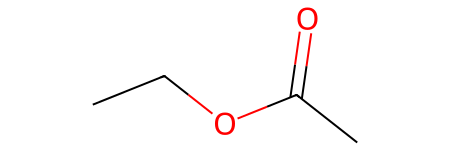

In [938]:
mol1 = rdkit.Chem.inchi.MolFromInchi(TEST_INCHI)
mol1

In [237]:
get_tanimoto(mol1, mol2)

0.2